In [1]:
!pip uninstall foscat -y
!pip install git+https://github.com/jmdelouis/FOSCAT.git@Test_cnn

Found existing installation: foscat 3.9.0
Uninstalling foscat-3.9.0:
  Successfully uninstalled foscat-3.9.0
  Cloning https://github.com/jmdelouis/FOSCAT.git (to revision Test_cnn) to /tmp/pip-req-build-2bksz443
  Running command git clone --filter=blob:none --quiet https://github.com/jmdelouis/FOSCAT.git /tmp/pip-req-build-2bksz443
  Running command git checkout -b Test_cnn --track origin/Test_cnn
  Switched to a new branch 'Test_cnn'
  Branch 'Test_cnn' set up to track remote branch 'Test_cnn' from 'origin'.
  Resolved https://github.com/jmdelouis/FOSCAT.git to commit d2ab2a39c608de8093a8fe294edc5f158134d75d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for foscat: filename=foscat-3.9.0-py3-none-any.whl size=105486 sha256=c21da5ffcfb34161ecbc3ab00fd255760b56bb1e3c249d71e698e20eb1e16d45
  Stored in directory: /tmp/pip-ephem-wheel-cache-qrl3epn0/wheels/ff/96/d2/008bb334cae773e397cf

In [2]:
!pip uninstall healpix-convolution -y
!pip install git+https://github.com/IAOCEA/healpix-convolution.git@WaveletComputation

Found existing installation: healpix-convolution 0.1.2.dev13+g43a743b
Uninstalling healpix-convolution-0.1.2.dev13+g43a743b:
  Successfully uninstalled healpix-convolution-0.1.2.dev13+g43a743b
  Cloning https://github.com/IAOCEA/healpix-convolution.git (to revision WaveletComputation) to /tmp/pip-req-build-43040kd9
  Running command git clone --filter=blob:none --quiet https://github.com/IAOCEA/healpix-convolution.git /tmp/pip-req-build-43040kd9
  Running command git checkout -b WaveletComputation --track origin/WaveletComputation
  Switched to a new branch 'WaveletComputation'
  Branch 'WaveletComputation' set up to track remote branch 'WaveletComputation' from 'origin'.
  Resolved https://github.com/IAOCEA/healpix-convolution.git to commit 43a743b21830e44002b7336cb3bc42e53ac5b1e2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for healpix-convolution: filename=healpix_convolution-0.

In [3]:
import numpy as np
import foscat.scat_cov as sc
import matplotlib.pyplot as plt
import sys
import healpy as hp
import foscat.Synthesis as synthe
import xarray as xr

In [4]:
dtotal=xr.open_zarr('data/test.zarr')
dtotal

<xarray.Dataset> Size: 90MB
Dimensions:    (depth: 8, latitude: 180, longitude: 324, time: 24)
Coordinates:
  * depth      (depth) float32 32B 0.494 1.541 2.646 3.819 ... 6.441 7.93 9.573
  * latitude   (latitude) float32 720B 46.03 46.05 46.08 ... 50.94 50.97 51.0
  * longitude  (longitude) float32 1kB -7.999 -7.971 -7.944 ... 0.9456 0.9733
  * time       (time) datetime64[ns] 192B 2025-03-20 ... 2025-03-20T23:00:00
Data variables:
    thetao     (time, depth, latitude, longitude) float64 90MB dask.array<chunksize=(1, 1, 180, 324), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    comment:      
    contact:      https://marine.copernicus.eu/contact
    institution:  NOW Systems (Spain)
    references:   http://marine.copernicus.eu/
    source:       NEMO3.6
    title:        Ocean 3D hourly mean fields for the Iberia-Biscay-Ireland (...

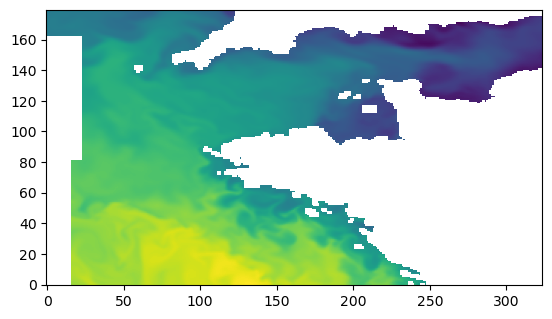

In [5]:
plt.imshow(dtotal.thetao.compute().values[12,0],origin='lower')

In [7]:
nside=2048
data = dtotal.thetao.compute().values[12,0,:,:]
longitude=np.tile(dtotal.longitude.compute().values,data.shape[0])
latitude=np.repeat(dtotal.latitude.compute().values,data.shape[1])
input_cell_ids = hp.ang2pix(nside,-longitude,latitude,lonlat=True,nest=True)
idx=np.where(~np.isnan(data.flatten()))[0]
input_cell_ids = np.unique(input_cell_ids[idx])

from scipy.interpolate import griddata
lon,lat = hp.pix2ang(nside,input_cell_ids,lonlat=True,nest=True)
points=np.zeros([idx.shape[0],2])
points[:,0]=longitude[idx]
points[:,1]=latitude[idx]

grid_z = griddata(points, data.flatten()[idx], (-lon, lat), method='cubic')
cell_ids=input_cell_ids[~np.isnan(grid_z)]
data=grid_z[~np.isnan(grid_z)]

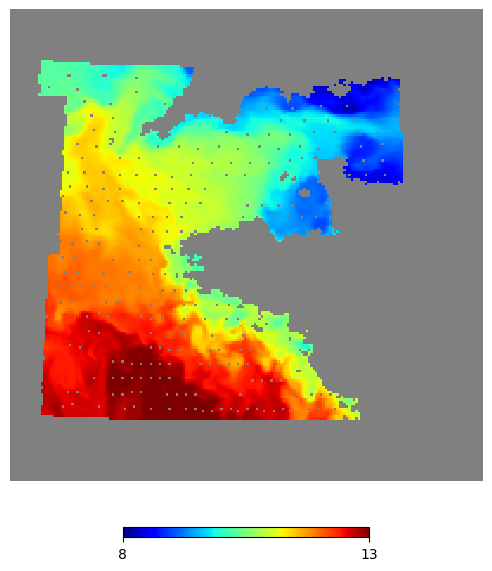

In [8]:
def plot_result(data,cell_ids,nside,hold=None,sub=None,title=None,unit=None,vmin=None,vmax=None):
    im=np.ones([12*nside**2])*hp.UNSEEN
    im[cell_ids]=data
    if vmin is None:
        vmin=data.min()
    if vmax is None:
        vmax=data.max()
    hp.gnomview(im,cmap='jet',nest=True,rot=[3.4,48.5],reso=2,hold=hold,sub=sub,notext=True,title=title,unit=unit,min=vmin,max=vmax)

plot_result(data,cell_ids,nside,vmin=8,vmax=13)

In [9]:
scat=sc.funct(BACKEND='torch')

/srv/conda/envs/notebook/lib/python3.12/site-packages/foscat/BkTorch.py:139: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718580740865/work/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  .to_sparse_csr()


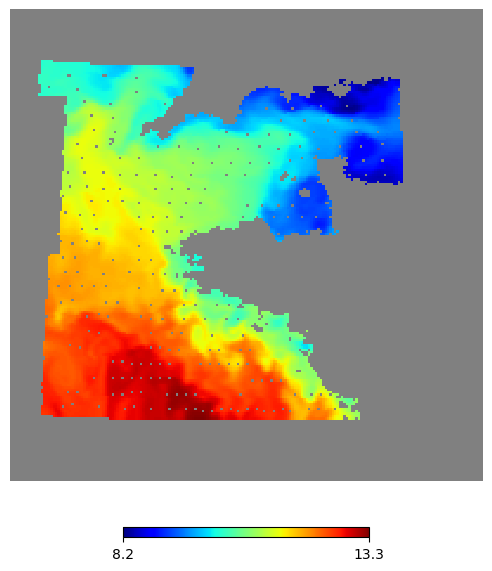

In [10]:
a=scat.smooth(scat.backend.bk_cast(data[None,:]),cell_ids=cell_ids,nside=nside)
plot_result(a.cpu().numpy()[0,:].real,cell_ids,nside)

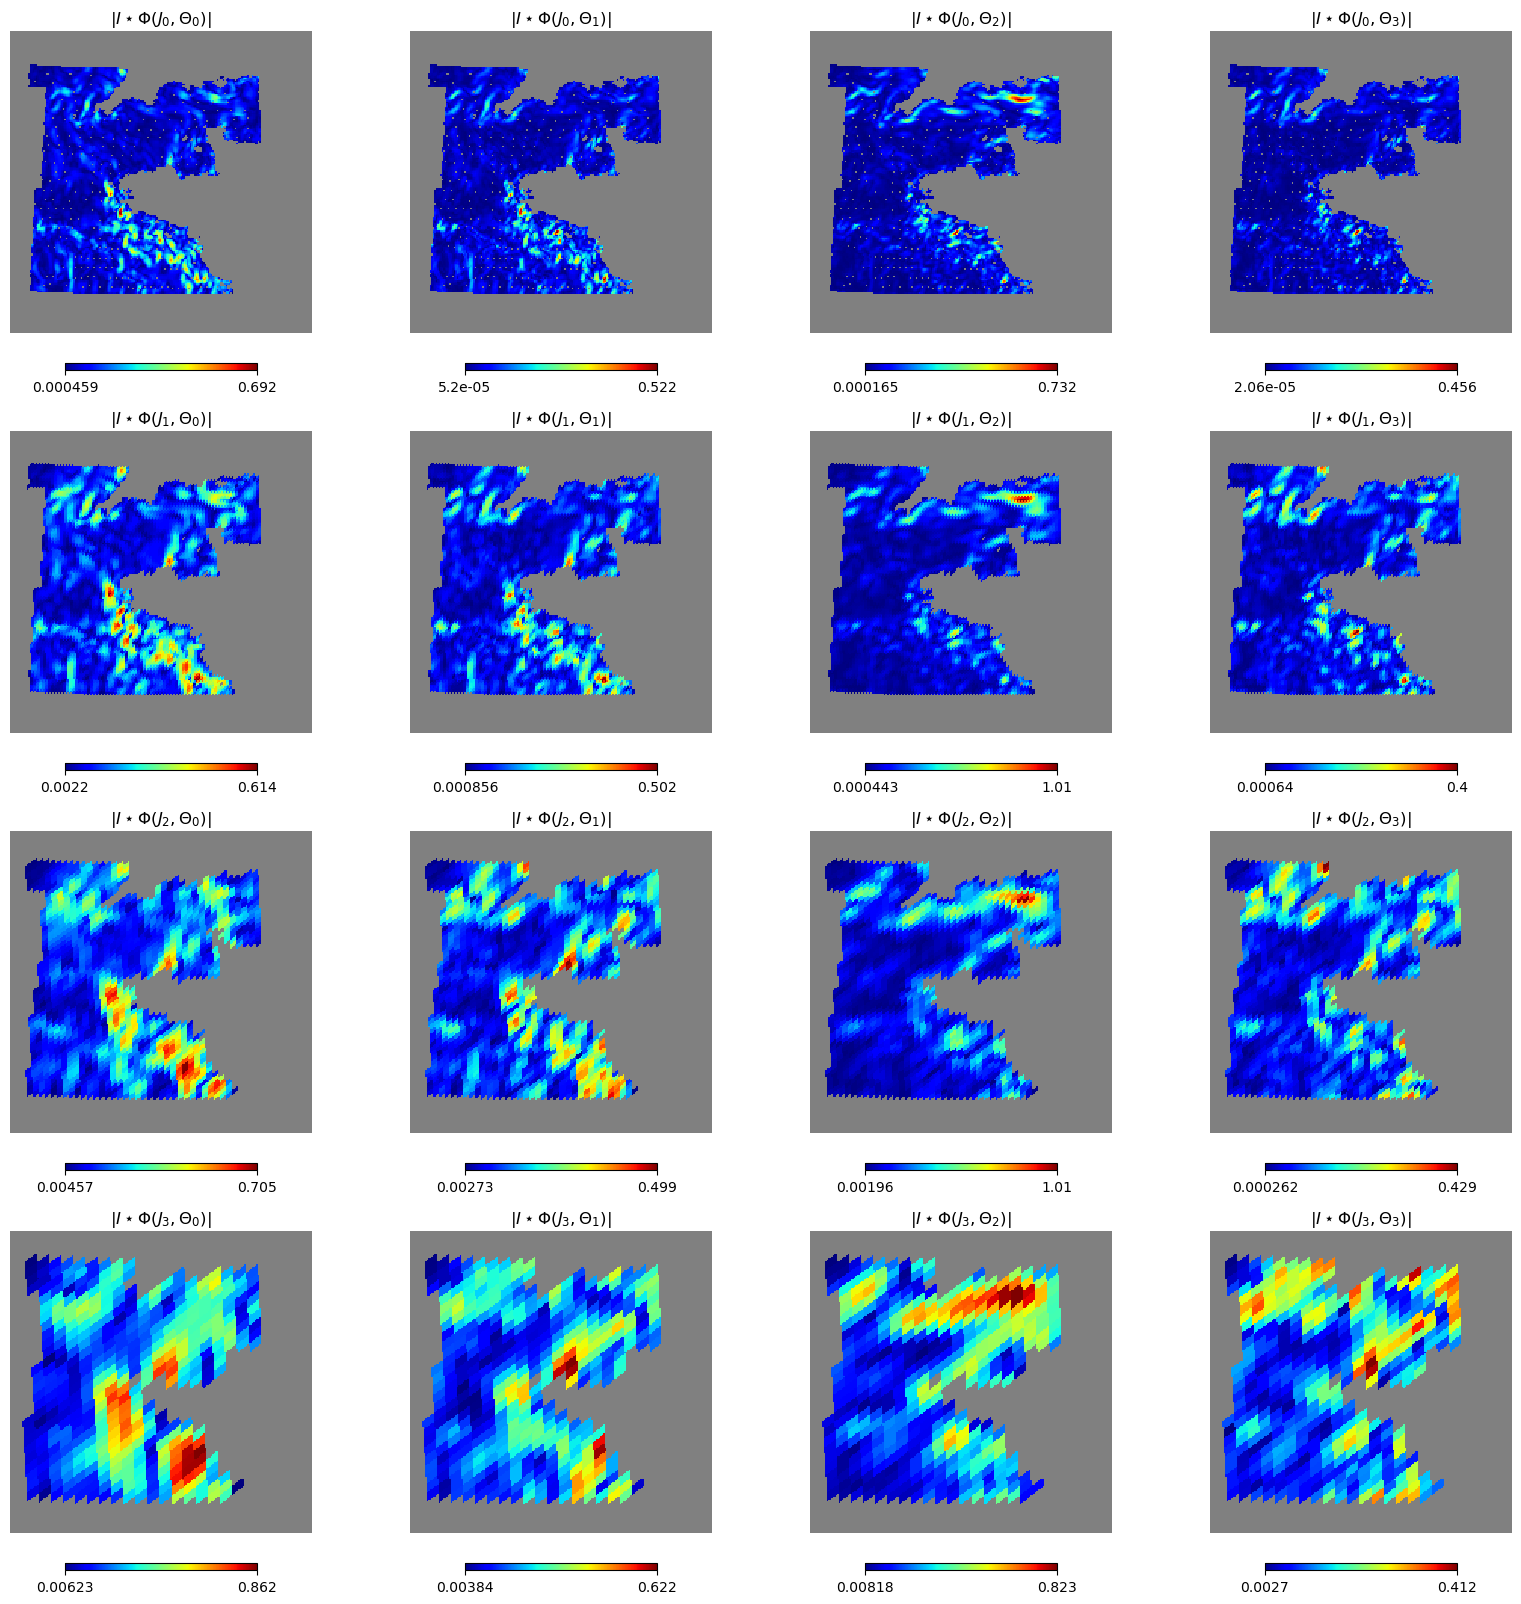

In [11]:
l_data=scat.backend.bk_cast(data[None,:]-np.median(data))

plt.figure(figsize=(16,16))
l_nside=nside
l_cell_ids=cell_ids.copy()
nscale=4
for l in range(nscale):
    wave=scat.convol(l_data,cell_ids=l_cell_ids,nside=l_nside)
    for k in range(4):
        plot_result(abs(wave.cpu().numpy()[0,:,k]),l_cell_ids,l_nside,hold=False,
                    sub=(nscale,4,1+k+4*l),unit='',title=r'$|I\star\Phi(J_%d,\Theta_%d)|$'%(l,k))
    l_data=scat.smooth(l_data,cell_ids=l_cell_ids,nside=l_nside)
    l_data,l_cell_ids=scat.ud_grade_2(l_data,cell_ids=l_cell_ids,nside=l_nside)
    l_nside//=2

In [12]:
a=scat.eval(data-np.median(data),Jmax=5,cell_ids=cell_ids,nside=nside)
b=scat.eval(np.random.randn(data.shape[0])*np.std(data),Jmax=5,cell_ids=cell_ids,nside=nside)

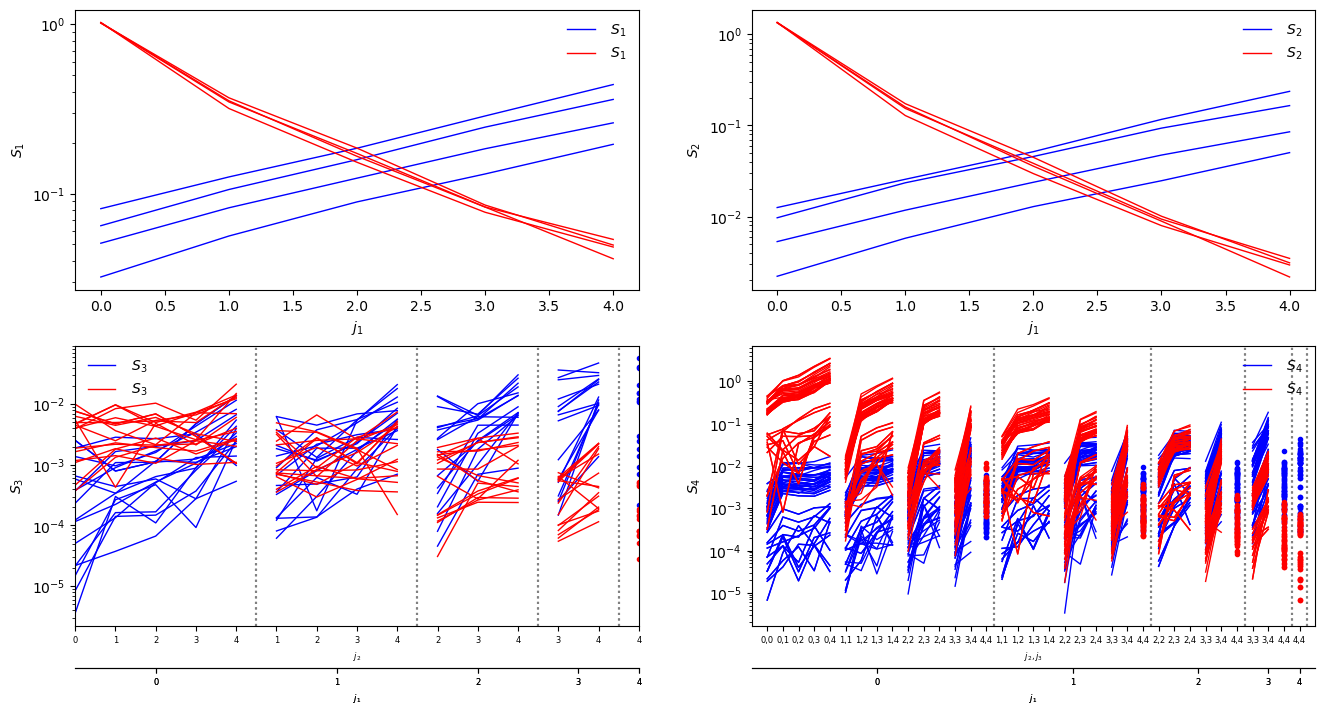

In [13]:
a.plot(color='b')
b.plot(hold=False,color='r')

In [14]:
def The_loss(u,scat_operator,args):
    ref  = args[0]
    sref = args[1]
    cell_ids =args[2]
    nside = args[3]

    # compute scattering covariance of the current synthetised map called u
    learn=scat_operator.eval(u,norm='self',cell_ids=cell_ids,nside=nside,Jmax=5)

    # make the difference withe the reference coordinates
    loss=scat_operator.reduce_distance(learn,ref,sigma=sref)

    return(loss)

In [15]:
ref,sref=scat.eval(data-np.median(data),Jmax=5,cell_ids=cell_ids,nside=nside,calc_var=True)

loss=synthe.Loss(The_loss,scat,ref,sref,cell_ids,nside)

sy = synthe.Synthesis([loss])

In [16]:
imap=np.random.randn(1,data.shape[0])*np.std(data)

omap=scat.to_numpy(sy.run(imap,
            EVAL_FREQUENCY=30,
            NUM_EPOCHS = 300))

Total number of loss  1
Itt      0 L=  1.49e+07 (  1.49e+07 ) 4.706s 
Itt     30 L=       118 (       118 ) 157.507s 
Itt     60 L=      12.9 (      12.9 ) 166.801s 
Itt     90 L=      6.99 (      6.99 ) 162.786s 
Itt    120 L=      4.83 (      4.83 ) 157.855s 
Itt    150 L=       3.7 (       3.7 ) 158.289s 
Itt    180 L=      2.86 (      2.86 ) 153.447s 
Itt    210 L=      2.18 (      2.18 ) 159.517s 
Itt    240 L=      1.72 (      1.72 ) 157.868s 
Itt    270 L=      1.45 (      1.45 ) 152.196s 
Itt    300 L=      1.28 (      1.28 ) 146.073s 
Final Loss  1.281435251235962


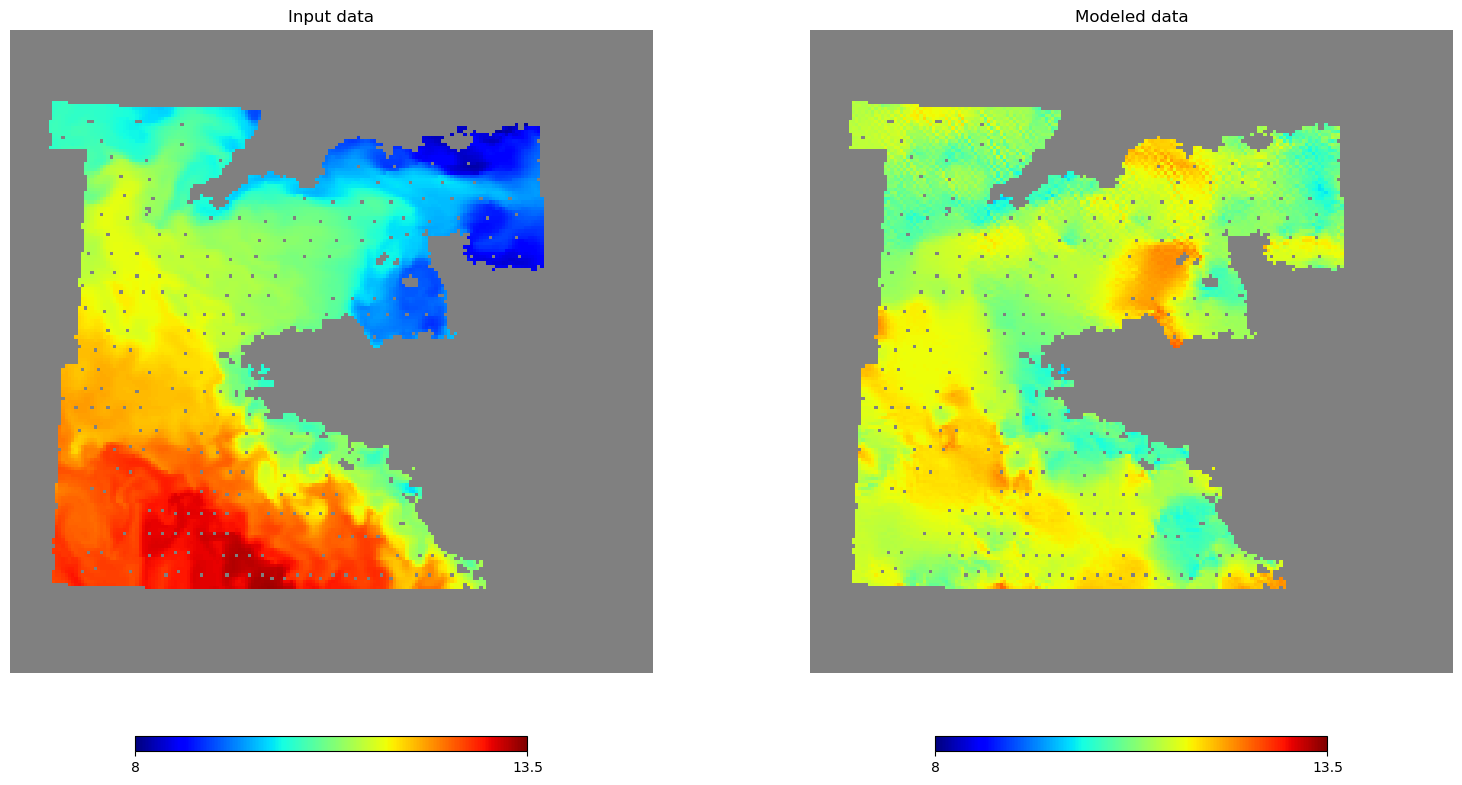

In [18]:
plt.figure(figsize=(16,8))
plot_result(data,cell_ids,nside,hold=False,sub=(1,2,1),title='Input data',vmin=8,vmax=13.5)
plot_result(omap+np.median(data),cell_ids,nside,hold=False,sub=(1,2,2),title='Modeled data',vmin=8,vmax=13.5)